This was made to run on colab

In [1]:
!pip3 install datasets
!pip3 install evaluate
!pip3 install accelerate -U
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 580.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 75.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 99.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [2]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation, Trainer, TrainingArguments
from torch import nn

from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from datasets import load_dataset

import json
from huggingface_hub import hf_hub_download
from torchvision.transforms import ColorJitter

import torch
import evaluate

import wandb

%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# weight and biases
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# Get dataset
hf_dataset_identifier = "Adriatogi/graffiti"
ds = load_dataset(hf_dataset_identifier)
ds['data'] = ds['data'].rename_column('image', 'pixel_values')

Generating data split:   0%|          | 0/120 [00:00<?, ? examples/s]

In [ ]:
# split data
ds = ds['data'].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

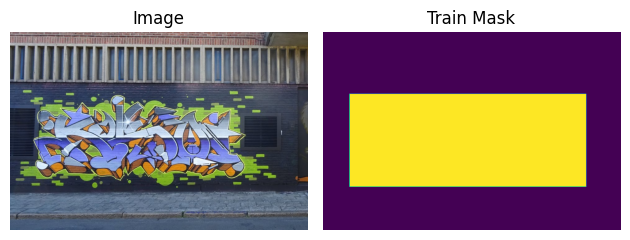

In [ ]:
# data pair example
fig, axes = plt.subplots(1, 2)

# Plot the first image on the first subplot
axes[0].imshow(train_ds[4]['pixel_values'])
axes[0].set_title('Image')

# Plot the second image on the second subplot
axes[1].imshow(train_ds[4]['label'])
axes[1].set_title('Train Mask')

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



In [ ]:
# download labels
filename = "id2label.json"
id2label = json.load(open(hf_hub_download(repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)
print(id2label)
print(num_labels)

id2label.json:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

{0: 'not_graf', 1: 'graf'}
2


In [ ]:
# train and eval transfors to generate more robust data. As well as segformer processor

jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)
processor = SegformerImageProcessor(reduce_labels=False)

def train_transforms(example_batch):
    images = [jitter(x) for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


def val_transforms(example_batch):
    images = [x for x in example_batch['pixel_values']]
    labels = [x for x in example_batch['label']]
    inputs = processor(images, labels)
    return inputs


# Set transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
# Make model
pretrained_model_name = "nvidia/mit-b0"
model = SegformerForSemanticSegmentation.from_pretrained(
    pretrained_model_name,
    id2label=id2label,
    label2id=label2id
)

config.json:   0%|          | 0.00/70.0k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/14.4M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
epochs = 10
lr = 0.0001
batch_size = 1

# model name to upload
hub_model_id = "segformer-b0-finetuned-segments-graffiti"

# arguements for model
training_args = TrainingArguments(
    "segformer-b0-finetuned-segments-graffiti-outputs",
    learning_rate=lr,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    save_total_limit=3,
    evaluation_strategy="steps",
    save_strategy="steps",
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=True,
    hub_model_id=hub_model_id,
    hub_strategy="end",
    report_to="wandb",
    warmup_ratio = 0.05
)

# weight and balances tracker
wandb.init(
        project="131_final",
        name = "b0_box_data_gpu_lr_0.0001_batch_1_discard",
        config={
            "epochs": epochs,
            "batch_size": batch_size,
            "lr": lr,
            }
        )

wandb: Currently logged in as: adriangamarra2018. Use `wandb login --relogin` to force relogin


In [ ]:
metric = evaluate.load("mean_iou")

def compute_metrics(eval_pred):
  with torch.no_grad():
    logits, labels = eval_pred
    logits_tensor = torch.from_numpy(logits)
    # scale the logits to the size of the label
    logits_tensor = nn.functional.interpolate(
        logits_tensor,
        size=labels.shape[-2:],
        mode="bilinear",
        align_corners=False,
    ).argmax(dim=1)

    pred_labels = logits_tensor.detach().cpu().numpy()
    # currently using _compute instead of compute
    # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
    metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=len(id2label),
            ignore_index=255,
            reduce_labels=processor.do_reduce_labels,
        )

    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

    return metrics

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
train_result = trainer.train()

Step,Training Loss,Validation Loss,Mean Iou,Mean Accuracy,Overall Accuracy,Accuracy Not Graf,Accuracy Graf,Iou Not Graf,Iou Graf
20,0.523500,0.613500,0.649949,0.801556,0.787853,0.692634,0.910478,0.647616,0.652282
40,0.574400,0.409096,0.723674,0.849648,0.839801,0.771380,0.927916,0.730492,0.716856
60,0.370500,0.395883,0.738922,0.859183,0.850025,0.786393,0.931972,0.746937,0.730907
80,0.189700,0.300600,0.774799,0.866602,0.877405,0.952473,0.780731,0.813897,0.735701
100,0.166200,0.289969,0.781665,0.872327,0.880929,0.940702,0.803952,0.816418,0.746913
120,0.453700,0.275130,0.795551,0.883007,0.888619,0.927614,0.838401,0.824193,0.766909
140,0.124900,0.271858,0.794365,0.884137,0.887320,0.909436,0.858837,0.819598,0.769133
160,0.498500,0.344097,0.746287,0.862956,0.854971,0.799487,0.926425,0.756280,0.736294
180,0.427900,0.291087,0.781881,0.876427,0.879595,0.901608,0.851245,0.808249,0.755512
200,0.177600,0.280785,0.792814,0.883094,0.886392,0.909304,0.856885,0.818360,0.767267


In [ ]:
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

***** train metrics *****
  epoch                    =       10.0
  total_flos               = 15671213GF
  train_loss               =      0.175
  train_runtime            = 0:06:17.82
  train_samples_per_second =      2.541
  train_steps_per_second   =      2.541


In [ ]:
# for graphing
train_losses = trainer.state.log_history
train_losses = [(step['epoch'], step['loss']) for step in train_losses if 'loss' in step.keys()]

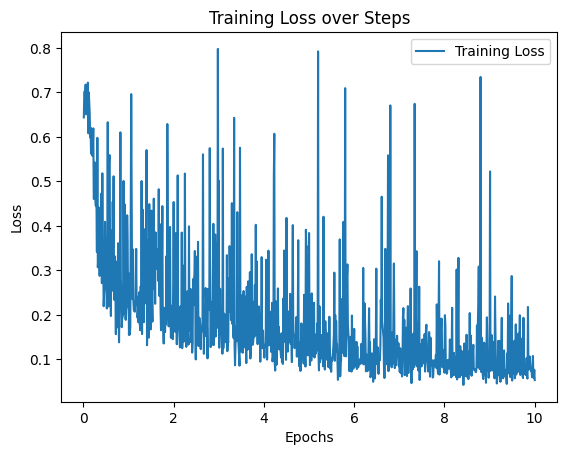

In [ ]:
epochs, losses = zip(*train_losses)
plt.plot(epochs, losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss over Steps")
plt.legend()
plt.show()

In [ ]:
# upload model
kwargs = {
    "tags": ["vision", "image-segmentation"],
    "finetuned_from": pretrained_model_name,
    "dataset": hf_dataset_identifier,
}

processor.push_to_hub(hub_model_id)
trainer.push_to_hub(**kwargs)

README.md:   0%|          | 0.00/9.35k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.98k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Adriatogi/segformer-b0-finetuned-segments-graffiti/commit/e92cf9f3a9eb860c0e729e7b05beb728ec912e88', commit_message='End of training', commit_description='', oid='e92cf9f3a9eb860c0e729e7b05beb728ec912e88', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
# get the dataset again because trainer edits it
hf_dataset_identifier = "Adriatogi/graffiti"
ds = load_dataset(hf_dataset_identifier)
ds['data'] = ds['data'].rename_column('image', 'pixel_values')
# split data
ds = ds['data'].train_test_split(test_size=0.2)
train_ds = ds["train"]
test_ds = ds["test"]

In [ ]:
# example pair
image = test_ds[0]['pixel_values']
gt_seg = test_ds[0]['label']
plt.imshow(gt_seg)

In [5]:
# get model
hub_model_id = "segformer-b0-finetuned-segments-graffiti"
processor = SegformerImageProcessor(reduce_labels=False)
model = SegformerForSemanticSegmentation.from_pretrained(f"Adriatogi/{hub_model_id}")

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/14.9M [00:00<?, ?B/s]

In [4]:
# or you can pass in an example image
image = Image.open("example.jpg")

In [6]:
# predict on image
inputs = processor(images=image, return_tensors="pt")
#inputs.to(device)
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# First, rescale logits to original image size
upsampled_logits = nn.functional.interpolate(
    logits,
    size=image.size[::-1], # (height, width)
    mode='bilinear',
    align_corners=False
)

# Second, apply argmax on the class dimension
pred_seg = upsampled_logits.argmax(dim=1)[0]

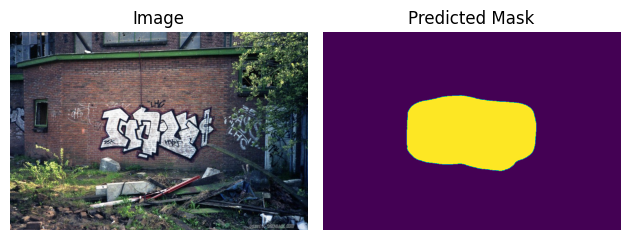

In [7]:
# plot original image and its predicted mask
fig, axes = plt.subplots(1, 2)

# Plot the first image on the first subplot
axes[0].imshow(image)
axes[0].set_title('Image')

# Plot the second image on the second subplot
axes[1].imshow(pred_seg.to('cpu'))
axes[1].set_title('Predicted Mask')

# Hide axis ticks and labels
for ax in axes:
    ax.axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

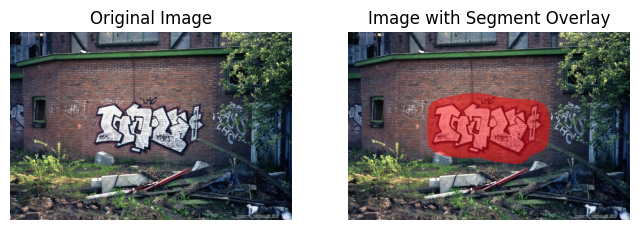

In [8]:
# overlap mask over image
masked_image = np.copy(image)
masked_image[pred_seg.to('cpu') == 1] = [255, 0, 0]  # Set masked regions to white (255)

# Display the original image
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
# Display the image with the mask overlay
plt.subplot(1, 2, 2)
plt.imshow(image, cmap='gray')
plt.imshow(masked_image, cmap='gray', alpha=0.5)  # Overlay with transparency
plt.title('Image with Segment Overlay')
plt.axis('off')

plt.show()